In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform

import pandas as pd 
import numpy as np

import glob
import cv2


from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.pyplot import figure
import os, time
from scipy.ndimage.filters import gaussian_filter1d
from datetime import date, datetime
from random import randrange

plt.rcParams['figure.figsize'] = [20, 8]

In [2]:
# for aimg in glob.glob('Image_dataset/Original/*.png'):
#     print(io.imread(aimg).shape, end='\t')

# Making Correspondence of coordinate and Image

Name = 201125_651, (X,Y) = (212, 86), Image Size = (625, 810)


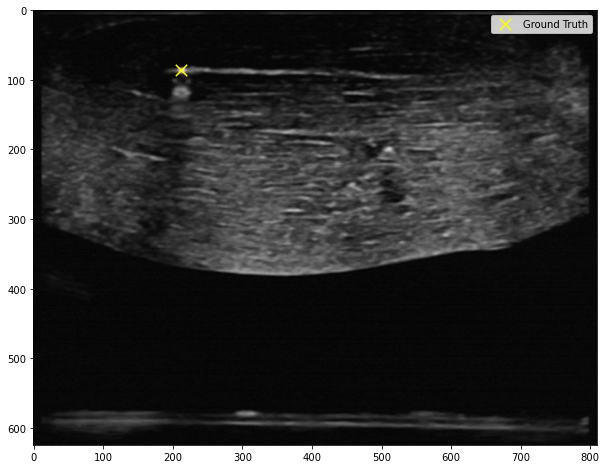

In [3]:
# See all images with the coordinate
pos = 4

df = pd.read_csv('x_y_co-ordinate_of_image_Dataset_ big.txt',sep='\t', header=None)
name, x, y = df.iloc[pos]
OriginalImg = plt.imread(f'Image_dataset/Original/{name}.png')
print(f'Name = {name}, (X,Y) = ({x}, {y}), Image Size = {OriginalImg.shape}')

# Show Figure with Image and Coordinate
plt.imshow(OriginalImg, cmap='gray')
plt.scatter(x,y, marker="x", color="yellow", s=130, label='Ground Truth')
plt.legend()
plt.show()



In [4]:
rimg = OriginalImg.reshape(1,OriginalImg.shape[0], OriginalImg.shape[1])
rimg.shape

(1, 625, 810)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Creating DataSet

In [6]:
class XYDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, Text_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = pd.read_csv(Text_file,sep='\t', header=None)
        self.root_dir = root_dir
        self.transform = transform
        
        length = len(self.df)
        self.data = np.zeros((length, 3, 256, 256))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        name, x, y = df.iloc[idx]
        
        if self.data[idx,:,:].sum()==0: 
            image = io.imread(f'{self.root_dir}/{name}.png')
            image = cv2.resize(image, (256,256))/256
            image = image.reshape(1, image.shape[0], image.shape[1])
            
            self.data[idx,0,:,:] = image
            self.data[idx,1,:,:] = image
            self.data[idx,1,:,:] = image
        
        
        image = self.data[idx,:,:,:]
        
        if self.transform:
            sample = self.transform(sample)
            
        image = torch.from_numpy(image).cuda()
        xy = torch.from_numpy(np.array([x, y])).cuda()
        return image.float(), xy, idx

## Train Loader and Test Loader

In [7]:
# Train and Test Size
TotalDataset = XYDataset(Text_file = 'x_y_co-ordinate_of_image_Dataset_ big.txt', root_dir = 'Image_dataset/Original/')

train_size = int(0.7 * len(TotalDataset))
test_size = len(TotalDataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(TotalDataset, [train_size, test_size])


train_loader = DataLoader(dataset = train_dataset, shuffle=False, batch_size = 10)
test_loader = DataLoader(dataset = test_dataset, shuffle=False, batch_size = 10)

In [8]:
# Just Test Not Nexessary
transformed_dataset = XYDataset(Text_file = 'x_y_co-ordinate_of_image_Dataset_ big.txt', root_dir = 'Image_dataset/Original/')

for i in range(len(train_loader)):
    A,B,c = transformed_dataset[i]

    print(i, A.shape, B)

    if i == 3:
        break

0 torch.Size([3, 256, 256]) tensor([333, 190], device='cuda:0')
1 torch.Size([3, 256, 256]) tensor([149, 105], device='cuda:0')
2 torch.Size([3, 256, 256]) tensor([150,  99], device='cuda:0')
3 torch.Size([3, 256, 256]) tensor([156,  96], device='cuda:0')


In [9]:
A = OriginalImg
A = A.reshape(1,A.shape[0], A.shape[1])
A.shape

(1, 625, 810)

## Previous Deep Learning Model

In [46]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1,6,5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,16,5)
    self.conv3 = nn.Conv2d(16,32,5)
    self.conv4 = nn.Conv2d(32,64,5)
    
    #self.fc1 = nn.Linear(16*5*5, 120)
    
    self.fc1 = nn.Linear(64*12*12, 120) 
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84,2)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = self.pool(F.relu(self.conv4(x)))
    # print('Shape = ', x.shape)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

# net = Net().float().to(device)

## New Deep Learning Architecture
I'm using efficientnetv2 (This is now my own network)

https://medium.com/codex/efficientnetv2-smaller-models-and-faster-training-fd174bed360c

https://ai.googleblog.com/2021/09/toward-fast-and-accurate-neural.html

In [47]:
# %load effnetv2.py
"""
Creates a EfficientNetV2 Model as defined in:
Mingxing Tan, Quoc V. Le. (2021). 
EfficientNetV2: Smaller Models and Faster Training
arXiv preprint arXiv:2104.00298.
import from https://github.com/d-li14/mobilenetv2.pytorch
"""

import torch
import torch.nn as nn
import math


classNumber = 2

__all__ = ['effnetv2_s', 'effnetv2_m', 'effnetv2_l', 'effnetv2_xl']


def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


# SiLU (Swish) activation function
if hasattr(nn, 'SiLU'):
    SiLU = nn.SiLU
else:
    # For compatibility with old PyTorch versions
    class SiLU(nn.Module):
        def forward(self, x):
            return x * torch.sigmoid(x)

 
class SELayer(nn.Module):
    def __init__(self, inp, oup, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(oup, _make_divisible(inp // reduction, 8)),
                SiLU(),
                nn.Linear(_make_divisible(inp // reduction, 8), oup),
                nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


def conv_3x3_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        SiLU()
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        SiLU()
    )


class MBConv(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio, use_se):
        super(MBConv, self).__init__()
        assert stride in [1, 2]

        hidden_dim = round(inp * expand_ratio)
        self.identity = stride == 1 and inp == oup
        if use_se:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                SiLU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                SiLU(),
                SELayer(inp, hidden_dim),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # fused
                nn.Conv2d(inp, hidden_dim, 3, stride, 1, bias=False),
                nn.BatchNorm2d(hidden_dim),
                SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )


    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)


class EffNetV2(nn.Module):
    def __init__(self, cfgs, num_classes=classNumber, width_mult=1.):
        super(EffNetV2, self).__init__()
        self.cfgs = cfgs

        # building first layer
        input_channel = _make_divisible(24 * width_mult, 8)
        layers = [conv_3x3_bn(3, input_channel, 2)]
        # building inverted residual blocks
        block = MBConv
        for t, c, n, s, use_se in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 8)
            for i in range(n):
                layers.append(block(input_channel, output_channel, s if i == 0 else 1, t, use_se))
                input_channel = output_channel
        self.features = nn.Sequential(*layers)
        # building last several layers
        output_channel = _make_divisible(1792 * width_mult, 8) if width_mult > 1.0 else 1792
        self.conv = conv_1x1_bn(input_channel, output_channel)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(output_channel, num_classes)

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.conv(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.001)
                m.bias.data.zero_()


def effnetv2_s(**kwargs):
    """
    Constructs a EfficientNetV2-S model
    """
    cfgs = [
        # t, c, n, s, SE
        [1,  24,  2, 1, 0],
        [4,  48,  4, 2, 0],
        [4,  64,  4, 2, 0],
        [4, 128,  6, 2, 1],
        [6, 160,  9, 1, 1],
        [6, 256, 15, 2, 1],
    ]
    return EffNetV2(cfgs, **kwargs)


def effnetv2_m(**kwargs):
    """
    Constructs a EfficientNetV2-M model
    """
    cfgs = [
        # t, c, n, s, SE
        [1,  24,  3, 1, 0],
        [4,  48,  5, 2, 0],
        [4,  80,  5, 2, 0],
        [4, 160,  7, 2, 1],
        [6, 176, 14, 1, 1],
        [6, 304, 18, 2, 1],
        [6, 512,  5, 1, 1],
    ]
    return EffNetV2(cfgs, **kwargs)


def effnetv2_l(**kwargs):
    """
    Constructs a EfficientNetV2-L model
    """
    cfgs = [
        # t, c, n, s, SE
        [1,  32,  4, 1, 0],
        [4,  64,  7, 2, 0],
        [4,  96,  7, 2, 0],
        [4, 192, 10, 2, 1],
        [6, 224, 19, 1, 1],
        [6, 384, 25, 2, 1],
        [6, 640,  7, 1, 1],
    ]
    return EffNetV2(cfgs, **kwargs)


def effnetv2_xl(**kwargs):
    """
    Constructs a EfficientNetV2-XL model
    """
    cfgs = [
        # t, c, n, s, SE
        [1,  32,  4, 1, 0],
        [4,  64,  8, 2, 0],
        [4,  96,  8, 2, 0],
        [4, 192, 16, 2, 1],
        [6, 256, 24, 1, 1],
        [6, 512, 32, 2, 1],
        [6, 640,  8, 1, 1],
    ]
    return EffNetV2(cfgs, **kwargs)

# net = effnetv2_s().to(device)

# Select the Network Architecture

In [ ]:
# net = Net().float().to(device)
net = effnetv2_s().to(device)

In [12]:
criterion = nn.L1Loss()#nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [13]:
for step, (x, y, idx) in enumerate(train_loader):
    output = net(x)
    break
output

tensor([[-1.6469e-03,  5.8276e-03],
        [-2.1155e-04,  2.8622e-03],
        [-5.1487e-03, -4.4241e-03],
        [-2.1315e-05, -1.6624e-02],
        [-4.1903e-03,  4.3106e-05],
        [-5.4716e-03, -7.9195e-03],
        [-4.6638e-03,  3.9171e-03],
        [-1.3255e-03,  6.3683e-03],
        [-3.0399e-03, -1.0512e-02],
        [-3.5835e-03,  2.6682e-03]], device='cuda:0', grad_fn=<AddmmBackward0>)

## Tensorboard
Not necessary

In [14]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()
# %load_ext tensorboard

## Function for Testing the Accuracy

In [15]:
def testAccuracy():
    test_loss = 0
    inc = 0
    for i, data in (enumerate(test_loader, 0)):
        optimizer.zero_grad()
        inputs, labels, idx = data #image, x cordinate
        output = net(inputs.float())
        output, labels = output.squeeze().cpu().detach().numpy(), labels.squeeze().cpu().detach().numpy()
        
# #         tError = np.absolute((labels-output).mean().item() #Manhattan distance
        tError = np.sqrt(np.sum(np.square(labels - output), axis=1)).mean().item() #Euclidean distance
        test_loss += tError
        inc = inc+1
        
    return test_loss/inc

In [16]:
testError = testAccuracy()

## Training

In [17]:
#@title For some reason this is not working
from tqdm import tqdm

EpochCount = 30
TetsErrorArray = []
LossArray = []

print('All Pixel Distance is calculated in Eucledian Distance')
print('epoch', '\t', 'Dataset Loss', '\t', 'Pixel difference', '\tTest Pixel Diff', '\tTest Accuracy')

for epoch in range(EpochCount):
    running_loss = 0
    net.train()
    for i, data in (enumerate(train_loader, 0)):
        
        optimizer.zero_grad()
        inputs, labels, idx = data #image, x cordinate
        output = net(inputs.float())
        output = output.squeeze()
        labels = labels.squeeze()
        loss = criterion(output, labels)

        LossArray.append(loss)        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    #print(epoch, '\t', round(running_loss,0), '\t', round(running_loss/3350,2))
    net.eval()
    testError = testAccuracy()
    print(epoch, '\t', round(running_loss,0), '\t', round(running_loss/3350,2), '\t\t\t', np.round((testError), 3), '\t\t\t', np.round((100-testError/717.5*100), 2), '%')
    TetsErrorArray.append(testError)
    
print('Finished Training')

All Pixel Distance is calculated in Eucledian Distance
epoch 	 Dataset Loss 	 Pixel difference 	Test Pixel Diff 	Test Accuracy
0 	 52088.0 	 15.55 			 220.748 			 69.23 %
1 	 19835.0 	 5.92 			 114.214 			 84.08 %
2 	 16694.0 	 4.98 			 111.853 			 84.41 %
3 	 15387.0 	 4.59 			 95.184 			 86.73 %
4 	 14099.0 	 4.21 			 88.072 			 87.73 %
5 	 13049.0 	 3.9 			 82.608 			 88.49 %
6 	 12305.0 	 3.67 			 65.435 			 90.88 %
7 	 10795.0 	 3.22 			 72.938 			 89.83 %
8 	 8303.0 	 2.48 			 42.25 			 94.11 %
9 	 6716.0 	 2.0 			 36.92 			 94.85 %
10 	 5909.0 	 1.76 			 17.094 			 97.62 %
11 	 5332.0 	 1.59 			 19.793 			 97.24 %
12 	 4347.0 	 1.3 			 11.768 			 98.36 %
13 	 3214.0 	 0.96 			 18.269 			 97.45 %
14 	 2588.0 	 0.77 			 19.356 			 97.3 %
15 	 2386.0 	 0.71 			 15.79 			 97.8 %
16 	 2588.0 	 0.77 			 13.041 			 98.18 %
17 	 2300.0 	 0.69 			 14.871 			 97.93 %
18 	 2003.0 	 0.6 			 14.639 			 97.96 %
19 	 1686.0 	 0.5 			 12.228 			 98.3 %
20 	 1566.0 	 0.47 			 7.158 			 99.0 %
21

In [ ]:
inputs, labels, idx = data

In [20]:
np.absolute((labels-output).cpu().detach()).mean().item()

11.41212272644043

## Plot the Test Accuracy over the Epoch

### It's common to get some pixel error
Usually even when you annotate anyting, you'll probably get 3 pixel difference because of your annotation is not pixel perfect. 

In [20]:
TetsErrorArray

[220.74816653462395,
 114.2135833268825,
 111.85251856733287,
 95.18363246540976,
 88.07233159229551,
 82.60824035818527,
 65.43514584076269,
 72.93844925930176,
 42.249677546172975,
 36.919645847396886,
 17.093648848978315,
 19.79302600702786,
 11.767954801700558,
 18.268679432230602,
 19.356477021735486,
 15.789667599837172,
 13.041484474586653,
 14.871078787319862,
 14.639397170244543,
 12.227867140321719,
 7.157730914721389,
 9.724818574213534,
 10.386545746168359,
 6.606824810505945,
 8.17351426851774,
 10.035293569300597,
 13.227861695819406,
 10.708533987346511,
 8.995695874509606,
 11.750742911290008]

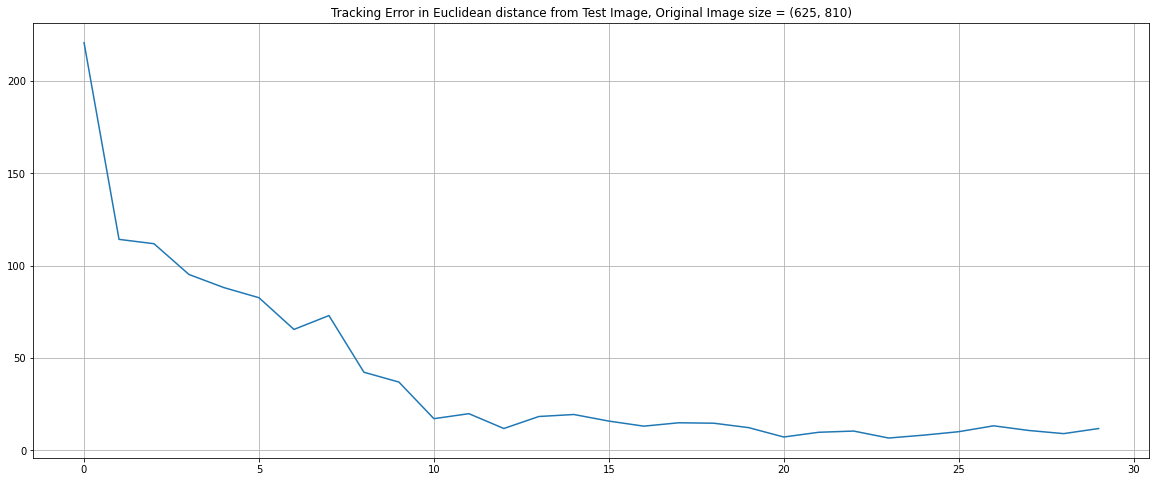

In [25]:
plt.plot(TetsErrorArray), plt.grid(), plt.title(f'Tracking Error in Euclidean distance from Test Image, Original Image size = {OriginalImg.shape}');

# Check the Output

In [26]:
Gt = (labels).cpu().detach().numpy()
Ot = (output).cpu().detach().numpy()

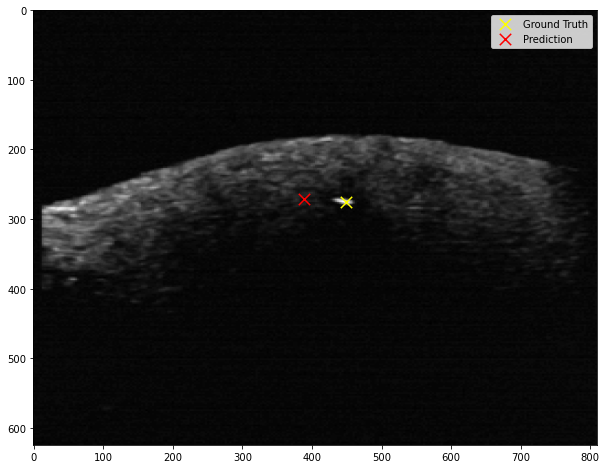

In [41]:
# Display different images in the Batch Size, Pos = 0~batch_size
pos = 4

image = inputs[pos, 0].cpu().detach().numpy().reshape((256,256))
image = cv2.resize(image, (810, 625), interpolation = cv2.INTER_AREA)
plt.imshow(image, cmap='gray')
#plt.plot(int(B[0][0]), int(B[0][1]), "og", markersize=10)
plt.scatter(int(Gt[pos][0]),int(Gt[pos][1]), marker="x", color="yellow", s=130, label='Ground Truth')
plt.scatter(int(Ot[pos][0]),int(Ot[pos][1]), marker="x", color="red", s=130,  label='Prediction')
plt.legend()
plt.show()

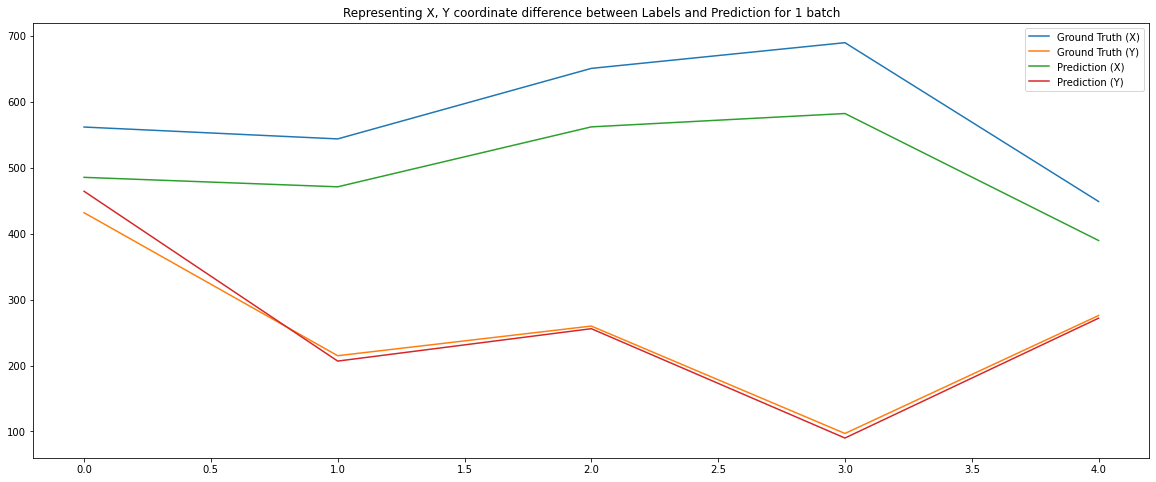

In [43]:
plt.plot(Gt[:,0], label='Ground Truth (X)')
plt.plot(Gt[:,1], label='Ground Truth (Y)')

plt.plot(Ot[:,0], label='Prediction (X)')
plt.plot(Ot[:,1], label='Prediction (Y)')

plt.title('Representing X, Y coordinate difference between Labels and Prediction for 1 batch')
plt.legend()
plt.show()

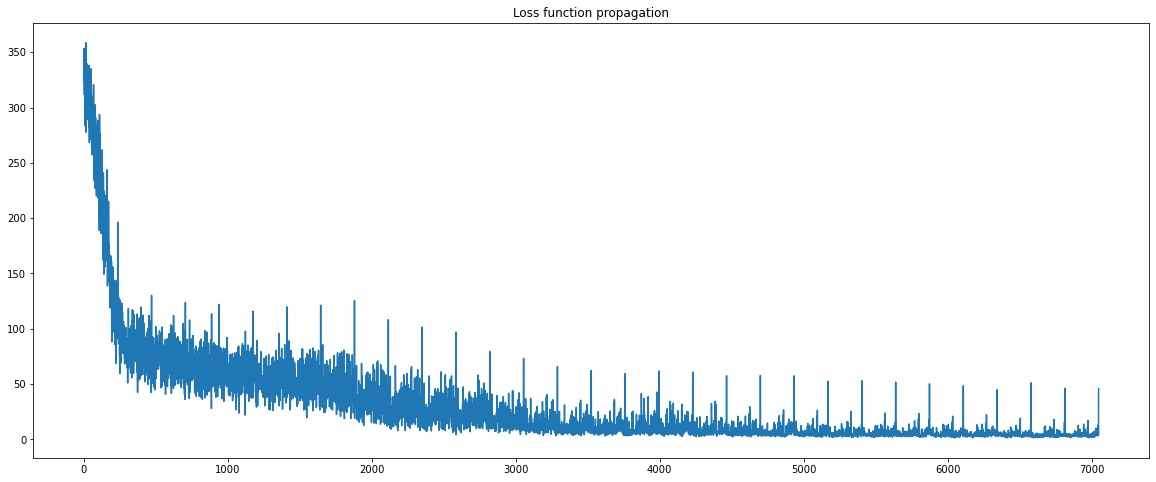

In [45]:
LossNumpyArray = [a.cpu().detach().numpy() for a in LossArray]
plt.plot(LossNumpyArray)
plt.title('Loss function propagation')
plt.show()